In [20]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
from scipy.ndimage import gaussian_filter

In [21]:
# to prepare the training data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [22]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cuda:1')
print(device)

cuda


In [23]:
class Hyperparameter():
    def __init__(self):
        self.dict = {}
        self.dict['optimizer'] = {}
        self.dict['optimizer']['lr'] = [1e-4, 5.5e-6]
        self.dict['optimizer']['beta'] = [(0.9, 0.999), (0.9, 0.999)]
        self.dict['optimizer']['eps'] = [1e-7, 1e-7]
        self.dict['optimizer']['method'] = 'Adam'
    
        self.dict['epoch'] = [100, 100]
        self.dict['batch_size'] = 32
        self.dict['patience'] = 5
        self.dict['min_delta'] = 1e-4
        
        self.dict['training_data'] = {}
#         self.dict['training_data']['path'] = '/home/muller_group/Documents/STEMalign-main/Ronchigram_simulation/simulated_data/preprocessed_forGPT/chenyu_25000/'
#         self.dict['training_data']['data'] = 'FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_128pxRonch_x25000.npy'
#         self.dict['training_data']['label_1'] = 'FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_newEmit_x25000.npy'
#         self.dict['training_data']['label_2'] = 'FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_defocus_x25000.npy'
        self.dict['training_data']['path'] = '/home/muller_group/Documents/STEMalign-main/Ronchigram_simulation/simulated_data/simulated_data_forNion/'
        self.dict['training_data']['data'] = 'Nion_all_ronch_xx.npy'
        self.dict['training_data']['label_1'] = 'Nion_all_emit_xx.npy'
        self.dict['training_data']['label_2'] = 'Nion_all_defocus_xx.npy'
        
        self.dict['training_data']['split'] = 0.8
        self.dict['training_data']['aperture'] = 0 # 0 for GPT
        self.dict['training_data']['limit'] = 40 # need to agree with Matlab simulation
        self.dict['training_data']['blur'] = 0.7
        
        self.dict['segmentation'] = {}
        self.dict['segmentation']['resize'] = (128, 128)
        self.dict['segmentation']['ratio'] = (0.97, 1.03)
        self.dict['segmentation']['scale'] = (0.97, 1.03)
        self.dict['segmentation']['normalize'] = None
        
        self.dict['architecture'] = {}
        self.dict['architecture']['dropout'] = 0.3
        self.dict['architecture']['linear_shape'] = [256]
        
        self.process = {}
        
        self.process['training'] = []
        self.process['validation'] = []
        
    def add_training_process(self, training_acc, validation_acc, epoch):
        if epoch == 0:
            self.process['training'].append([])
            self.process['validation'].append([])
        if torch.is_tensor(training_acc):
            training_acc = training_acc.cpu().detach().numpy()
        if torch.is_tensor(validation_acc):
            validation_acc = validation_acc.cpu().detach().numpy()
        self.process['training'][-1].append(training_acc)
        self.process['validation'][-1].append(validation_acc)
        return
    
    
    def save_result(self, path):
        with open(path + 'hyperparameter.pkl', 'wb') as f:
            pickle.dump(self.dict, f)
        with open(path + 'training_log.pkl', 'wb') as f:
            pickle.dump(self.process, f)

In [24]:
par = Hyperparameter()

In [25]:
## define net

In [26]:
## 
input_path = par.dict['training_data']['path']
train_data = np.load(input_path + par.dict['training_data']['data'])
print(train_data.shape)

emit = np.load(input_path + par.dict['training_data']['label_1'])
emit_normalized = (emit - np.amin(emit))/(np.amax(emit) - np.amin(emit))
train_label = emit_normalized

defocus = np.load(input_path + par.dict['training_data']['label_2'])
defocus_normalized = (defocus - np.amin(defocus))/(np.amax(defocus) - np.amin(defocus))
train_label = (emit_normalized + defocus_normalized) / 2

(55000, 128, 128)


In [27]:
## should be consistent with the preprocessing file
print(np.amin(emit))
print(np.amax(emit))
print(np.amin(defocus))
print(np.amax(defocus))

0.0001501544084037349
148.84530524989404
0.0001006621087710156
3999.9954455795505


In [28]:
emit.shape

(55000,)

In [29]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input    

def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [30]:
if par.dict['training_data']['aperture'] != 0:
    aperture_mask = aperture_generator(128, par.dict['training_data']['limit'], 
                                       par.dict['training_data']['aperture'])

In [31]:
class RonchigramDataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.data[index, :, :].astype('float')
        img = scale_range(img, 0.05, 1.0)
        
        if par.dict['training_data']['aperture'] != 0:
            img = img * aperture_mask
            
        if par.dict['training_data']['blur'] != 0:
            img = gaussian_filter(img, sigma = par.dict['training_data']['blur'])
            
        img = scale_range(img, 0, 1)
        new_channel = np.zeros(img.shape)
        img = np.dstack((img, new_channel, new_channel))
        img = Image.fromarray(np.uint8(img * 255))
        y_label = torch.tensor(float(self.labels[index]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [32]:
transform = transforms.Compose(
        [
#             transforms.Resize(par.dict['segmentation']['resize']),
           # transforms.RandomRotation(90),
            transforms.RandomResizedCrop((128, 128), scale = par.dict['segmentation']['scale'], ratio = par.dict['segmentation']['ratio']),
            transforms.ToTensor(),
            # TODO: need to add random shear here
            # option to normalize a tensor with mean and standard deviation, similar to featurewise center in Keras
#             transforms.Normalize((1.0, 1.0, 1.0), (1.0, 1.0, 1.0)),
        ]
    )

In [33]:
# training hyperparameters
train_CNN = False
batch_size = par.dict['batch_size']
shuffle = True
pin_memory = True
num_workers = 1

In [34]:
dataset = RonchigramDataset(train_data, train_label, transform = transform)

n_train = int(len(train_data) * par.dict['training_data']['split'])
n_val = len(train_data) - n_train
train_set, validation_set = torch.utils.data.random_split(dataset,[n_train,n_val])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)

validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [35]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [36]:
npimg = torchvision.utils.make_grid(images).numpy()
np.transpose(npimg, (1, 2, 0))[:,:,0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.54901963, ..., 0.49411765, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.49411765, ..., 0.49411765, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [37]:
dataiter.next()[0].shape

torch.Size([32, 3, 128, 128])

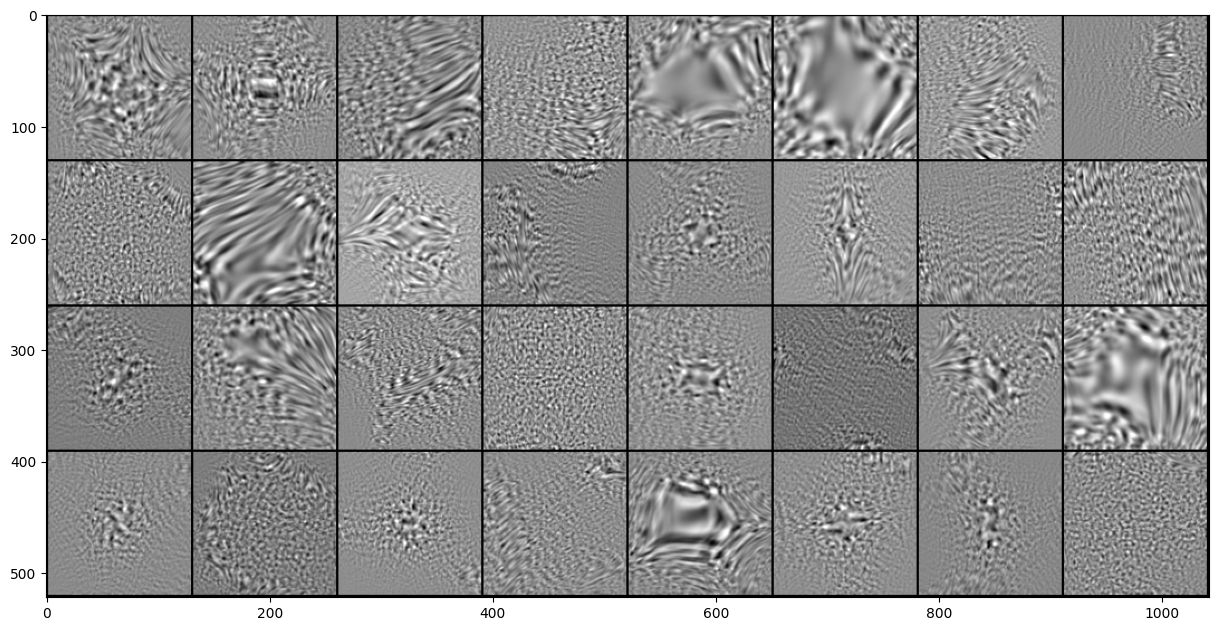

tensor([0.1341, 0.2355, 0.1176, 0.1514, 0.0580, 0.0227, 0.3345, 0.6948, 0.4728,
        0.0575, 0.1794, 0.9248, 0.2528, 0.3960, 0.3064, 0.1411, 0.3343, 0.1096,
        0.7123, 0.4611, 0.2030, 0.2606, 0.2125, 0.0353, 0.4264, 0.4106, 0.3810,
        0.2358, 0.0862, 0.2619, 0.3109, 0.5084])


In [38]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))[:,:,0], cmap='gray', vmin=0, vmax=0.9)
#     plt.colorbar()
    plt.show()

fig = plt.figure(figsize = [15,9])
# imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(images))
print(labels)

In [39]:
# Call the CNN model and start 

# model = Net(dropout = par.dict['architecture']['dropout'], linear_shape = par.dict['architecture']['linear_shape'][0]).to(device)
# model.load_pretrained() # this loads the pretrained weights from VGG - dm852
# model.lock_base() # freeze training for all layers 

criterion = nn.MSELoss(reduction = 'mean')

In [40]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 1)

if torch.cuda.is_available():
    model.to('cuda')

Using cache found in /home/muller_group/.cache/torch/hub/pytorch_vision_v0.10.0
/home/muller_group/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/muller_group/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
def check_accuracy(loader, model):
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    sum_MSE = 0
    counter = 0
    loss = nn.MSELoss(reduction = 'mean')
    model.eval()
    
    # define two lists to save truth and predictions, for the plot only.
    y_list = torch.empty(0).to(device = device)
    pred_list = torch.empty(0).to(device = device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            pred = torch.squeeze(model(x))
            pred_list = torch.cat((pred_list, pred), 0)
            y_list = torch.cat((y_list, y), 0)
            sum_MSE += loss(pred, y) * y.shape[0]
            counter += y.shape[0]
    
    fig, ax = plt.subplots(1,1, figsize = (5,5))
    img = ax.scatter(y_list.cpu().numpy(), pred_list.cpu().numpy(), s = 1)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100),'--', c = 'red')
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Truth',fontsize = 16)
    ax.set_ylabel('Prediction', fontsize = 16)
    plt.show()
    
    model.train()
#     print( f"Got accuracy {float(sum_MSE)/float(counter):.6f}" )   
    return f"{float(sum_MSE)/float(counter):.6f}"
    
#     model.train()

In [42]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience = 5, min_delta = 0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [43]:
def train():
    early_stopping = EarlyStopping(patience = par.dict['patience'], min_delta = par.dict['min_delta'])
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total = len(train_loader), leave = True)
        
        if epoch % 2 == 0:
            val_acc = check_accuracy(validation_loader, model)
            loop.set_postfix(val_acc = val_acc)
            early_stopping(float(val_acc))
            if early_stopping.early_stop:
                par.add_training_process(acc_loss / counter , float(val_acc), epoch)
                break
                
        acc_loss = 0
        counter = 0
        
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = torch.squeeze(model(imgs))
            loss = criterion(outputs, labels)
            acc_loss += loss * labels.shape[0]
            counter += labels.shape[0]
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())
        
        par.add_training_process(acc_loss / counter , val_acc, epoch)
        print(f"Training acc: {float(acc_loss) / float(counter):.6f}, Validation accuracy {float(val_acc):.6f}")

  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


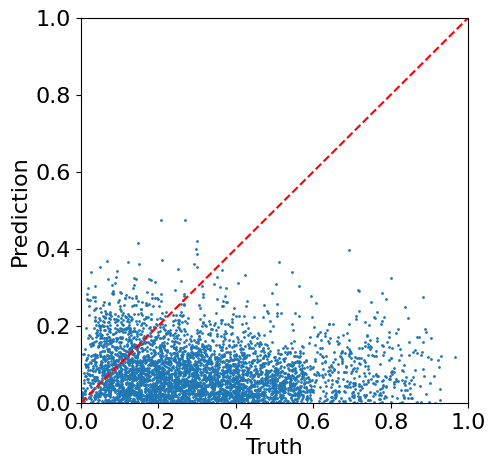

Epoch [0/100]: 100%|█| 1375/1375 [02:16<00:00, 10.05it/s, loss=0.00778


Training acc: 0.018719, Validation accuracy 0.202218


Epoch [1/100]: 100%|█| 1375/1375 [02:10<00:00, 10.50it/s, loss=0.00238


Training acc: 0.004417, Validation accuracy 0.202218


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


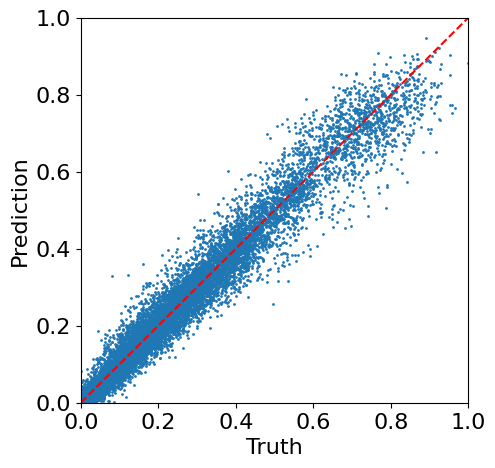

Epoch [2/100]: 100%|█| 1375/1375 [02:22<00:00,  9.63it/s, loss=0.00207


Training acc: 0.003008, Validation accuracy 0.002212


Epoch [3/100]: 100%|█| 1375/1375 [02:06<00:00, 10.88it/s, loss=0.00138


Training acc: 0.002227, Validation accuracy 0.002212


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


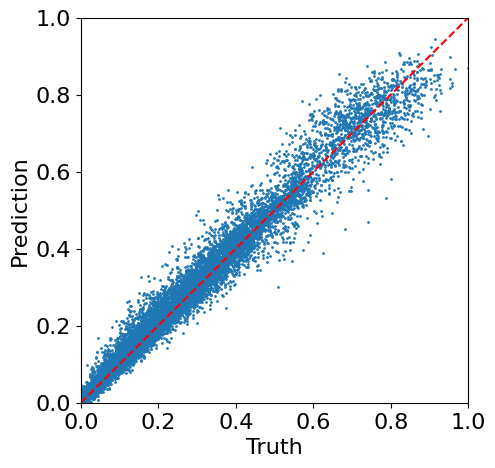

Epoch [4/100]: 100%|█| 1375/1375 [02:19<00:00,  9.87it/s, loss=0.00271


Training acc: 0.001844, Validation accuracy 0.001544


Epoch [5/100]: 100%|█| 1375/1375 [02:07<00:00, 10.75it/s, loss=0.0018]


Training acc: 0.001556, Validation accuracy 0.001544


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


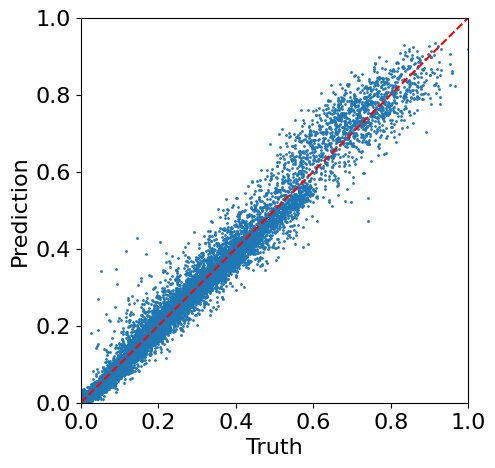

Epoch [6/100]: 100%|█| 1375/1375 [02:19<00:00,  9.83it/s, loss=0.00079


Training acc: 0.001411, Validation accuracy 0.001371


Epoch [7/100]: 100%|█| 1375/1375 [02:01<00:00, 11.31it/s, loss=0.00103


Training acc: 0.001275, Validation accuracy 0.001371


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


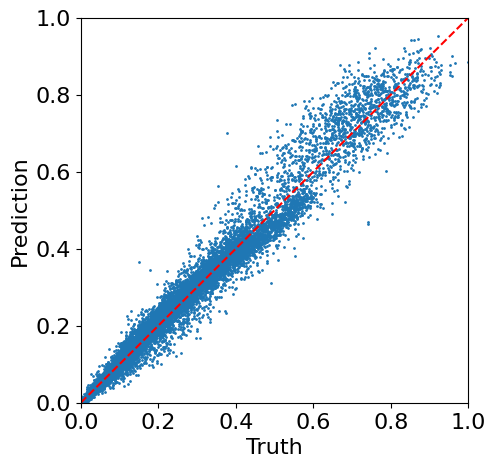

  0%|                      | 0/1375 [00:14<?, ?it/s, val_acc=0.001547]

INFO: Early stopping counter 1 of 5


Epoch [8/100]: 100%|█| 1375/1375 [02:21<00:00,  9.72it/s, loss=0.00055


Training acc: 0.001073, Validation accuracy 0.001547


Epoch [9/100]: 100%|█| 1375/1375 [02:08<00:00, 10.70it/s, loss=0.00053


Training acc: 0.000972, Validation accuracy 0.001547


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


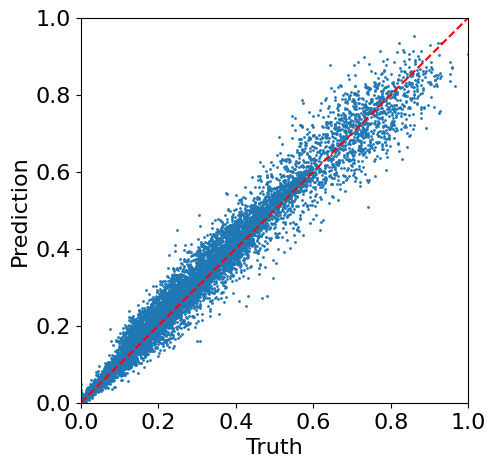

  0%|                      | 0/1375 [00:14<?, ?it/s, val_acc=0.001515]

INFO: Early stopping counter 2 of 5


Epoch [10/100]: 100%|█| 1375/1375 [02:24<00:00,  9.49it/s, loss=0.0003


Training acc: 0.000956, Validation accuracy 0.001515


Epoch [11/100]: 100%|█| 1375/1375 [02:07<00:00, 10.77it/s, loss=0.0002


Training acc: 0.000802, Validation accuracy 0.001515


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


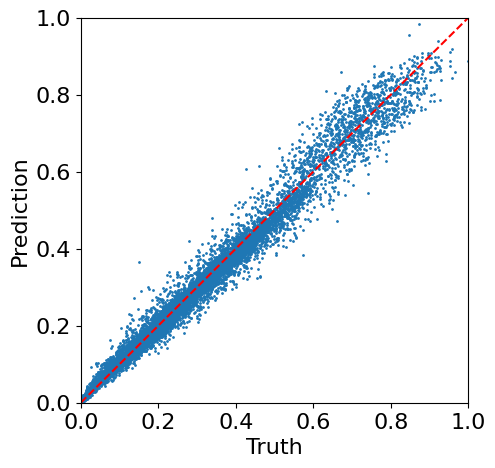

Epoch [12/100]: 100%|█| 1375/1375 [02:25<00:00,  9.44it/s, loss=0.0004


Training acc: 0.000716, Validation accuracy 0.000887


Epoch [13/100]: 100%|█| 1375/1375 [02:04<00:00, 11.04it/s, loss=0.0005


Training acc: 0.000744, Validation accuracy 0.000887


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


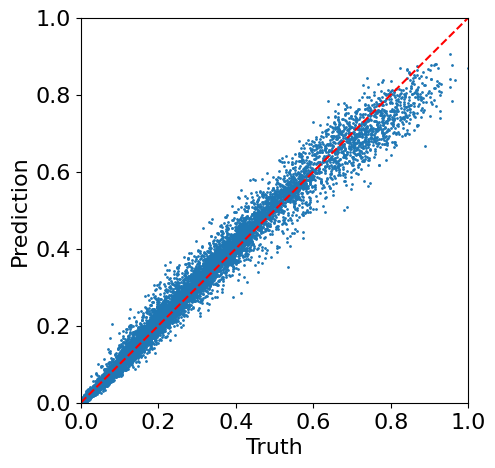

  0%|                      | 0/1375 [00:13<?, ?it/s, val_acc=0.001017]

INFO: Early stopping counter 1 of 5


Epoch [14/100]: 100%|█| 1375/1375 [02:19<00:00,  9.85it/s, loss=0.0004


Training acc: 0.000622, Validation accuracy 0.001017


Epoch [15/100]: 100%|█| 1375/1375 [02:05<00:00, 10.95it/s, loss=0.0005


Training acc: 0.000590, Validation accuracy 0.001017


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


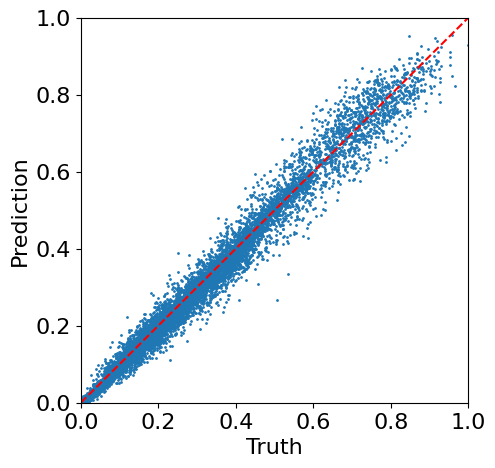

  0%|                      | 0/1375 [00:14<?, ?it/s, val_acc=0.000901]

INFO: Early stopping counter 2 of 5


Epoch [16/100]: 100%|█| 1375/1375 [02:16<00:00, 10.04it/s, loss=0.0006


Training acc: 0.000567, Validation accuracy 0.000901


Epoch [17/100]: 100%|█| 1375/1375 [01:59<00:00, 11.54it/s, loss=0.0003


Training acc: 0.000526, Validation accuracy 0.000901


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


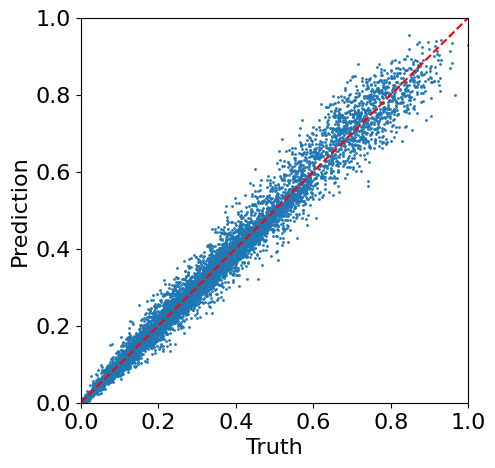

  0%|                      | 0/1375 [00:14<?, ?it/s, val_acc=0.000814]

INFO: Early stopping counter 3 of 5


Epoch [18/100]: 100%|█| 1375/1375 [02:21<00:00,  9.75it/s, loss=0.0008


Training acc: 0.000452, Validation accuracy 0.000814


Epoch [19/100]: 100%|█| 1375/1375 [02:01<00:00, 11.35it/s, loss=0.0001


Training acc: 0.000468, Validation accuracy 0.000814


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


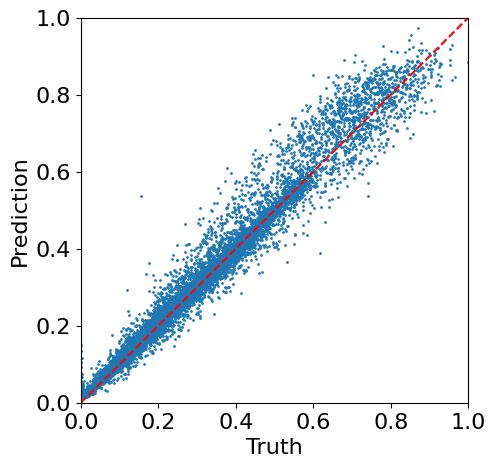

  0%|                      | 0/1375 [00:14<?, ?it/s, val_acc=0.001448]

INFO: Early stopping counter 4 of 5


Epoch [20/100]: 100%|█| 1375/1375 [02:20<00:00,  9.80it/s, loss=0.0005


Training acc: 0.000454, Validation accuracy 0.001448


Epoch [21/100]: 100%|█| 1375/1375 [02:02<00:00, 11.19it/s, loss=0.0002


Training acc: 0.000418, Validation accuracy 0.001448


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


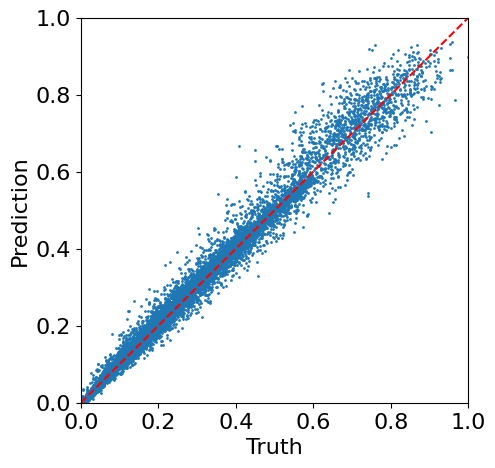

  0%|                      | 0/1375 [00:13<?, ?it/s, val_acc=0.000912]

INFO: Early stopping counter 5 of 5
INFO: Early stopping


In [44]:
stage = 0
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


  0%|                      | 0/1375 [00:29<?, ?it/s, val_acc=0.000912]


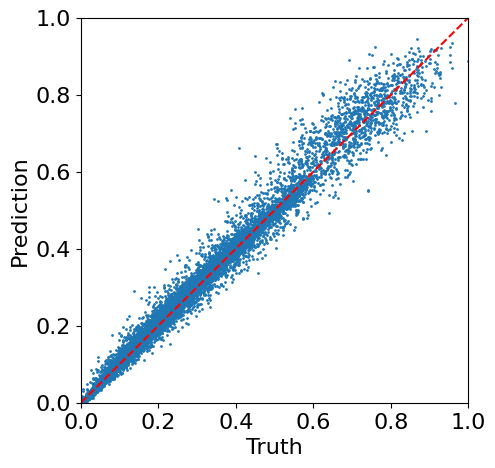


Epoch [0/100]:   0%|          | 0/1375 [00:16<?, ?it/s, loss=0.000178]
Epoch [0/100]:   0%| | 1/1375 [00:16<6:14:02, 16.33s/it, loss=0.000178
Epoch [0/100]:   0%| | 1/1375 [00:16<6:14:02, 16.33s/it, loss=0.000178
Epoch [0/100]:   0%| | 1/1375 [00:16<6:14:02, 16.33s/it, loss=0.000206
Epoch [0/100]:   0%| | 1/1375 [00:16<6:14:02, 16.33s/it, loss=0.000206
Epoch [0/100]:   0%| | 1/1375 [00:16<6:14:02, 16.33s/it, loss=0.000364
Epoch [0/100]:   0%| | 3/1375 [00:16<1:38:30,  4.31s/it, loss=0.000364
Epoch [0/100]:   0%| | 3/1375 [00:16<1:38:30,  4.31s/it, loss=0.000364
Epoch [0/100]:   0%| | 3/1375 [00:16<1:38:30,  4.31s/it, loss=0.000167
Epoch [0/100]:   0%| | 3/1375 [00:16<1:38:30,  4.31s/it, loss=0.000167
Epoch [0/100]:   0%| | 3/1375 [00:16<1:38:30,  4.31s/it, loss=0.000723
Epoch [0/100]:   3%| | 42/1375 [00:20<02:07, 10.43it/s, loss=0.000205]


Epoch [0/100]:   6%| | 85/1375 [00:24<02:03, 10.47it/s, loss=0.000249]


Epoch [0/100]:   7%| | 99/1375 [00:26<02:04, 10.25it/s, loss=0.000276]
Epoch [0/100]:   7%| | 101/1375 [00:26<02:03, 10.34it/s, loss=0.000276
Epoch [0/100]:   7%| | 101/1375 [00:26<02:03, 10.34it/s, loss=0.000276
Epoch [0/100]:   7%| | 101/1375 [00:26<02:03, 10.34it/s, loss=0.000355
Epoch [0/100]:   7%| | 101/1375 [00:26<02:03, 10.34it/s, loss=0.000355
Epoch [0/100]:   7%| | 101/1375 [00:26<02:03, 10.34it/s, loss=0.000479
Epoch [0/100]:   7%| | 103/1375 [00:26<02:03, 10.32it/s, loss=0.000479
Epoch [0/100]:   7%| | 103/1375 [00:26<02:03, 10.32it/s, loss=0.000479
Epoch [0/100]:   7%| | 103/1375 [00:26<02:03, 10.32it/s, loss=0.000294
Epoch [0/100]:   7%| | 103/1375 [00:26<02:03, 10.32it/s, loss=0.000294
Epoch [0/100]:   7%| | 103/1375 [00:26<02:03, 10.32it/s, loss=0.000398
Epoch [0/100]:   8%| | 105/1375 [00:26<02:04, 10.22it/s, loss=0.000398
Epoch [0/100]:   8%| | 105/1375 [00:26<02:04, 10.22it/s, loss=0.000398
Epoch [0/100]:   8%| | 105/1375 [00:26<02:04, 10.22it/s, loss=0.000247
Epoch 

Epoch [0/100]:   9%| | 129/1375 [00:28<02:01, 10.25it/s, loss=0.000234
Epoch [0/100]:   9%| | 129/1375 [00:28<02:01, 10.25it/s, loss=0.000162
Epoch [0/100]:   9%| | 129/1375 [00:29<02:01, 10.25it/s, loss=0.000162
Epoch [0/100]:   9%| | 129/1375 [00:29<02:01, 10.25it/s, loss=0.000393
Epoch [0/100]:  10%| | 131/1375 [00:29<02:02, 10.16it/s, loss=0.000393
Epoch [0/100]:  10%| | 131/1375 [00:29<02:02, 10.16it/s, loss=0.000393
Epoch [0/100]:  10%| | 131/1375 [00:29<02:02, 10.16it/s, loss=0.00031]
Epoch [0/100]:  10%| | 131/1375 [00:29<02:02, 10.16it/s, loss=0.000397
Epoch [0/100]:  10%| | 133/1375 [00:29<02:01, 10.25it/s, loss=0.000397
Epoch [0/100]:  10%| | 133/1375 [00:29<02:01, 10.25it/s, loss=0.000397
Epoch [0/100]:  10%| | 133/1375 [00:29<02:01, 10.25it/s, loss=0.000558
Epoch [0/100]:  10%| | 133/1375 [00:29<02:01, 10.25it/s, loss=0.000558
Epoch [0/100]:  10%| | 135/1375 [00:29<02:00, 10.29it/s, loss=0.00014]
Epoch [0/100]:  10%| | 135/1375 [00:29<02:00, 10.29it/s, loss=0.000193
Epoch 

Epoch [0/100]:  13%|▏| 173/1375 [00:33<01:55, 10.40it/s, loss=0.000197
Epoch [0/100]:  13%|▏| 173/1375 [00:33<01:55, 10.40it/s, loss=0.000143
Epoch [0/100]:  13%|▏| 173/1375 [00:33<01:55, 10.40it/s, loss=0.000143
Epoch [0/100]:  13%|▏| 173/1375 [00:33<01:55, 10.40it/s, loss=0.000137
Epoch [0/100]:  13%|▏| 175/1375 [00:33<01:54, 10.50it/s, loss=0.000137
Epoch [0/100]:  13%|▏| 175/1375 [00:33<01:54, 10.50it/s, loss=0.000137
Epoch [0/100]:  13%|▏| 175/1375 [00:33<01:54, 10.50it/s, loss=0.000443
Epoch [0/100]:  13%|▏| 175/1375 [00:33<01:54, 10.50it/s, loss=0.000443
Epoch [0/100]:  13%|▏| 175/1375 [00:33<01:54, 10.50it/s, loss=0.000134
Epoch [0/100]:  13%|▏| 177/1375 [00:33<01:55, 10.33it/s, loss=0.000134
Epoch [0/100]:  13%|▏| 177/1375 [00:33<01:55, 10.33it/s, loss=0.000134
Epoch [0/100]:  13%|▏| 177/1375 [00:33<01:55, 10.33it/s, loss=0.00015]
Epoch [0/100]:  13%|▏| 177/1375 [00:33<01:55, 10.33it/s, loss=0.000239
Epoch [0/100]:  13%|▏| 179/1375 [00:33<01:57, 10.18it/s, loss=0.000239
Epoch 

Epoch [0/100]:  16%|▏| 217/1375 [00:37<01:52, 10.32it/s, loss=0.000226
Epoch [0/100]:  16%|▏| 217/1375 [00:37<01:52, 10.32it/s, loss=0.000173
Epoch [0/100]:  16%|▏| 217/1375 [00:37<01:52, 10.32it/s, loss=0.000173
Epoch [0/100]:  16%|▏| 217/1375 [00:37<01:52, 10.32it/s, loss=0.000106
Epoch [0/100]:  16%|▏| 219/1375 [00:37<01:51, 10.34it/s, loss=0.000106
Epoch [0/100]:  16%|▏| 219/1375 [00:37<01:51, 10.34it/s, loss=0.000106
Epoch [0/100]:  16%|▏| 219/1375 [00:37<01:51, 10.34it/s, loss=0.000183
Epoch [0/100]:  16%|▏| 219/1375 [00:37<01:51, 10.34it/s, loss=0.000183
Epoch [0/100]:  16%|▏| 221/1375 [00:37<01:51, 10.38it/s, loss=0.00017]
Epoch [0/100]:  16%|▏| 221/1375 [00:37<01:51, 10.38it/s, loss=0.000389
Epoch [0/100]:  16%|▏| 221/1375 [00:37<01:51, 10.38it/s, loss=0.000389
Epoch [0/100]:  16%|▏| 221/1375 [00:37<01:51, 10.38it/s, loss=0.000231
Epoch [0/100]:  16%|▏| 223/1375 [00:37<01:50, 10.42it/s, loss=0.000231
Epoch [0/100]:  16%|▏| 223/1375 [00:38<01:50, 10.42it/s, loss=0.000231
Epoch 

Epoch [0/100]:  19%|▏| 261/1375 [00:41<01:45, 10.59it/s, loss=0.000136
Epoch [0/100]:  19%|▏| 261/1375 [00:41<01:45, 10.59it/s, loss=0.000412
Epoch [0/100]:  19%|▏| 261/1375 [00:41<01:45, 10.59it/s, loss=0.000412
Epoch [0/100]:  19%|▏| 261/1375 [00:41<01:45, 10.59it/s, loss=0.000314
Epoch [0/100]:  19%|▏| 263/1375 [00:41<01:45, 10.54it/s, loss=0.000314
Epoch [0/100]:  19%|▏| 263/1375 [00:41<01:45, 10.54it/s, loss=0.000314
Epoch [0/100]:  19%|▏| 263/1375 [00:41<01:45, 10.54it/s, loss=0.000195
Epoch [0/100]:  19%|▏| 263/1375 [00:41<01:45, 10.54it/s, loss=0.000195
Epoch [0/100]:  19%|▏| 265/1375 [00:42<01:45, 10.54it/s, loss=0.00026]
Epoch [0/100]:  19%|▏| 265/1375 [00:42<01:45, 10.54it/s, loss=0.000304
Epoch [0/100]:  19%|▏| 265/1375 [00:42<01:45, 10.54it/s, loss=0.000304
Epoch [0/100]:  19%|▏| 265/1375 [00:42<01:45, 10.54it/s, loss=0.000275
Epoch [0/100]:  19%|▏| 267/1375 [00:42<01:43, 10.65it/s, loss=0.000275
Epoch [0/100]:  19%|▏| 267/1375 [00:42<01:43, 10.65it/s, loss=0.000275
Epoch 

Epoch [0/100]:  22%|▏| 305/1375 [00:45<01:40, 10.67it/s, loss=0.000189
Epoch [0/100]:  22%|▏| 305/1375 [00:45<01:40, 10.67it/s, loss=0.000131
Epoch [0/100]:  22%|▏| 305/1375 [00:45<01:40, 10.67it/s, loss=0.000131
Epoch [0/100]:  22%|▏| 307/1375 [00:46<01:40, 10.59it/s, loss=0.00019]
Epoch [0/100]:  22%|▏| 307/1375 [00:46<01:40, 10.59it/s, loss=0.000134
Epoch [0/100]:  22%|▏| 307/1375 [00:46<01:40, 10.59it/s, loss=0.000134
Epoch [0/100]:  22%|▏| 307/1375 [00:46<01:40, 10.59it/s, loss=0.000115
Epoch [0/100]:  22%|▏| 309/1375 [00:46<01:41, 10.54it/s, loss=0.000115
Epoch [0/100]:  22%|▏| 309/1375 [00:46<01:41, 10.54it/s, loss=0.000115
Epoch [0/100]:  22%|▏| 309/1375 [00:46<01:41, 10.54it/s, loss=0.000186
Epoch [0/100]:  22%|▏| 309/1375 [00:46<01:41, 10.54it/s, loss=0.000186
Epoch [0/100]:  22%|▏| 309/1375 [00:46<01:41, 10.54it/s, loss=0.000418
Epoch [0/100]:  23%|▏| 311/1375 [00:46<01:42, 10.38it/s, loss=0.000418
Epoch [0/100]:  23%|▏| 311/1375 [00:46<01:42, 10.38it/s, loss=0.000418
Epoch 

Epoch [0/100]:  25%|▎| 349/1375 [00:50<01:37, 10.57it/s, loss=0.000271
Epoch [0/100]:  25%|▎| 349/1375 [00:50<01:37, 10.57it/s, loss=0.00033]
Epoch [0/100]:  25%|▎| 349/1375 [00:50<01:37, 10.57it/s, loss=0.000234
Epoch [0/100]:  26%|▎| 351/1375 [00:50<01:35, 10.71it/s, loss=0.000234
Epoch [0/100]:  26%|▎| 351/1375 [00:50<01:35, 10.71it/s, loss=0.000234
Epoch [0/100]:  26%|▎| 351/1375 [00:50<01:35, 10.71it/s, loss=0.000179
Epoch [0/100]:  26%|▎| 351/1375 [00:50<01:35, 10.71it/s, loss=0.000179
Epoch [0/100]:  26%|▎| 353/1375 [00:50<01:36, 10.63it/s, loss=0.00018]
Epoch [0/100]:  26%|▎| 353/1375 [00:50<01:36, 10.63it/s, loss=0.000133
Epoch [0/100]:  26%|▎| 353/1375 [00:50<01:36, 10.63it/s, loss=0.000133
Epoch [0/100]:  26%|▎| 353/1375 [00:50<01:36, 10.63it/s, loss=0.000323
Epoch [0/100]:  26%|▎| 355/1375 [00:50<01:36, 10.58it/s, loss=0.000323
Epoch [0/100]:  26%|▎| 355/1375 [00:50<01:36, 10.58it/s, loss=0.000323
Epoch [0/100]:  26%|▎| 355/1375 [00:50<01:36, 10.58it/s, loss=0.000123
Epoch 

Epoch [0/100]:  29%|▎| 393/1375 [00:54<01:32, 10.65it/s, loss=0.000206
Epoch [0/100]:  29%|▎| 393/1375 [00:54<01:32, 10.65it/s, loss=0.000144
Epoch [0/100]:  29%|▎| 393/1375 [00:54<01:32, 10.65it/s, loss=0.000144
Epoch [0/100]:  29%|▎| 393/1375 [00:54<01:32, 10.65it/s, loss=0.000333
Epoch [0/100]:  29%|▎| 395/1375 [00:54<01:32, 10.57it/s, loss=0.000333
Epoch [0/100]:  29%|▎| 395/1375 [00:54<01:32, 10.57it/s, loss=0.000333
Epoch [0/100]:  29%|▌ | 395/1375 [00:54<01:32, 10.57it/s, loss=8.8e-5]
Epoch [0/100]:  29%|▎| 395/1375 [00:54<01:32, 10.57it/s, loss=0.000145
Epoch [0/100]:  29%|▎| 397/1375 [00:54<01:33, 10.44it/s, loss=0.000145
Epoch [0/100]:  29%|▎| 397/1375 [00:54<01:33, 10.44it/s, loss=0.000145
Epoch [0/100]:  29%|▎| 397/1375 [00:54<01:33, 10.44it/s, loss=0.000153
Epoch [0/100]:  29%|▎| 397/1375 [00:54<01:33, 10.44it/s, loss=0.000153
Epoch [0/100]:  29%|▎| 397/1375 [00:54<01:33, 10.44it/s, loss=0.000176
Epoch [0/100]:  29%|▎| 399/1375 [00:54<01:33, 10.43it/s, loss=0.000176
Epoch 

Epoch [0/100]:  32%|▎| 437/1375 [00:58<01:22, 11.35it/s, loss=0.000136
Epoch [0/100]:  32%|▎| 437/1375 [00:58<01:22, 11.35it/s, loss=0.000233
Epoch [0/100]:  32%|▎| 437/1375 [00:58<01:22, 11.35it/s, loss=0.000233
Epoch [0/100]:  32%|▎| 437/1375 [00:58<01:22, 11.35it/s, loss=0.000145
Epoch [0/100]:  32%|▎| 439/1375 [00:58<01:21, 11.43it/s, loss=0.000145
Epoch [0/100]:  32%|▎| 439/1375 [00:58<01:21, 11.43it/s, loss=0.000145
Epoch [0/100]:  32%|▎| 439/1375 [00:58<01:21, 11.43it/s, loss=0.000171
Epoch [0/100]:  32%|▎| 439/1375 [00:58<01:21, 11.43it/s, loss=0.000171
Epoch [0/100]:  32%|▎| 439/1375 [00:58<01:21, 11.43it/s, loss=0.000176
Epoch [0/100]:  32%|▎| 441/1375 [00:58<01:21, 11.42it/s, loss=0.000176
Epoch [0/100]:  32%|▎| 441/1375 [00:58<01:21, 11.42it/s, loss=0.000176
Epoch [0/100]:  32%|▎| 441/1375 [00:58<01:21, 11.42it/s, loss=0.000156
Epoch [0/100]:  32%|▎| 441/1375 [00:58<01:21, 11.42it/s, loss=0.000156
Epoch [0/100]:  32%|▎| 441/1375 [00:58<01:21, 11.42it/s, loss=0.000145
Epoch 

Epoch [0/100]:  35%|▎| 481/1375 [01:02<01:23, 10.68it/s, loss=0.000102
Epoch [0/100]:  35%|▎| 481/1375 [01:02<01:23, 10.68it/s, loss=0.000159
Epoch [0/100]:  35%|▎| 481/1375 [01:02<01:23, 10.68it/s, loss=0.000159
Epoch [0/100]:  35%|▎| 481/1375 [01:02<01:23, 10.68it/s, loss=0.000216
Epoch [0/100]:  35%|▎| 483/1375 [01:02<01:23, 10.65it/s, loss=0.000216
Epoch [0/100]:  35%|▎| 483/1375 [01:02<01:23, 10.65it/s, loss=0.000216
Epoch [0/100]:  35%|▎| 483/1375 [01:02<01:23, 10.65it/s, loss=0.000163
Epoch [0/100]:  35%|▎| 483/1375 [01:02<01:23, 10.65it/s, loss=0.000163
Epoch [0/100]:  35%|▎| 483/1375 [01:02<01:23, 10.65it/s, loss=0.000135
Epoch [0/100]:  35%|▎| 485/1375 [01:02<01:22, 10.73it/s, loss=0.000135
Epoch [0/100]:  35%|▎| 485/1375 [01:02<01:22, 10.73it/s, loss=0.000135
Epoch [0/100]:  35%|▎| 485/1375 [01:02<01:22, 10.73it/s, loss=0.000113
Epoch [0/100]:  35%|▎| 485/1375 [01:02<01:22, 10.73it/s, loss=0.000113
Epoch [0/100]:  35%|▎| 485/1375 [01:02<01:22, 10.73it/s, loss=0.000164
Epoch 

Epoch [0/100]:  38%|▍| 525/1375 [01:06<01:21, 10.38it/s, loss=0.000136
Epoch [0/100]:  38%|▍| 525/1375 [01:06<01:21, 10.38it/s, loss=0.000168
Epoch [0/100]:  38%|▍| 525/1375 [01:06<01:21, 10.38it/s, loss=0.000168
Epoch [0/100]:  38%|▍| 525/1375 [01:06<01:21, 10.38it/s, loss=0.000176
Epoch [0/100]:  38%|▍| 527/1375 [01:06<01:20, 10.54it/s, loss=0.000176
Epoch [0/100]:  38%|▍| 527/1375 [01:06<01:20, 10.54it/s, loss=0.000176
Epoch [0/100]:  38%|▍| 529/1375 [01:06<01:20, 10.53it/s, loss=0.00022]
Epoch [0/100]:  38%|▍| 529/1375 [01:06<01:20, 10.53it/s, loss=0.000205
Epoch [0/100]:  38%|▍| 529/1375 [01:06<01:20, 10.53it/s, loss=0.000205
Epoch [0/100]:  38%|▍| 529/1375 [01:06<01:20, 10.53it/s, loss=0.000475
Epoch [0/100]:  39%|▍| 531/1375 [01:06<01:20, 10.51it/s, loss=0.000475
Epoch [0/100]:  39%|▍| 531/1375 [01:07<01:20, 10.51it/s, loss=0.000475
Epoch [0/100]:  39%|▍| 531/1375 [01:07<01:20, 10.51it/s, loss=0.000285
Epoch [0/100]:  39%|▍| 531/1375 [01:07<01:20, 10.51it/s, loss=0.000285
Epoch 

Epoch [0/100]:  41%|▍| 569/1375 [01:10<01:17, 10.44it/s, loss=0.00031]
Epoch [0/100]:  41%|▍| 569/1375 [01:10<01:17, 10.44it/s, loss=0.000202
Epoch [0/100]:  41%|▍| 569/1375 [01:10<01:17, 10.44it/s, loss=0.000202
Epoch [0/100]:  41%|▍| 569/1375 [01:10<01:17, 10.44it/s, loss=0.000236
Epoch [0/100]:  42%|▍| 571/1375 [01:10<01:16, 10.47it/s, loss=0.000236
Epoch [0/100]:  42%|▍| 571/1375 [01:10<01:16, 10.47it/s, loss=0.000236
Epoch [0/100]:  42%|▍| 571/1375 [01:10<01:16, 10.47it/s, loss=0.000249
Epoch [0/100]:  42%|▍| 571/1375 [01:10<01:16, 10.47it/s, loss=0.000249
Epoch [0/100]:  42%|▍| 571/1375 [01:10<01:16, 10.47it/s, loss=0.000245
Epoch [0/100]:  42%|▍| 573/1375 [01:10<01:16, 10.45it/s, loss=0.000245
Epoch [0/100]:  42%|▍| 573/1375 [01:11<01:16, 10.45it/s, loss=0.000245
Epoch [0/100]:  42%|▍| 573/1375 [01:11<01:16, 10.45it/s, loss=0.000154
Epoch [0/100]:  42%|▍| 573/1375 [01:11<01:16, 10.45it/s, loss=0.000154
Epoch [0/100]:  42%|▍| 573/1375 [01:11<01:16, 10.45it/s, loss=0.000237
Epoch 

Epoch [0/100]:  45%|▍| 613/1375 [01:14<01:13, 10.37it/s, loss=0.000211
Epoch [0/100]:  45%|▍| 613/1375 [01:14<01:13, 10.37it/s, loss=0.000175
Epoch [0/100]:  45%|▍| 613/1375 [01:14<01:13, 10.37it/s, loss=0.000175
Epoch [0/100]:  45%|▍| 613/1375 [01:14<01:13, 10.37it/s, loss=0.000245
Epoch [0/100]:  45%|▍| 615/1375 [01:14<01:13, 10.31it/s, loss=0.000245
Epoch [0/100]:  45%|▍| 615/1375 [01:15<01:13, 10.31it/s, loss=0.000245
Epoch [0/100]:  45%|▍| 615/1375 [01:15<01:13, 10.31it/s, loss=0.000278
Epoch [0/100]:  45%|▍| 615/1375 [01:15<01:13, 10.31it/s, loss=0.000278
Epoch [0/100]:  45%|▍| 615/1375 [01:15<01:13, 10.31it/s, loss=0.000146
Epoch [0/100]:  45%|▍| 617/1375 [01:15<01:13, 10.35it/s, loss=0.000146
Epoch [0/100]:  45%|▍| 617/1375 [01:15<01:13, 10.35it/s, loss=0.000146
Epoch [0/100]:  45%|▍| 617/1375 [01:15<01:13, 10.35it/s, loss=0.000201
Epoch [0/100]:  45%|▍| 617/1375 [01:15<01:13, 10.35it/s, loss=0.000201
Epoch [0/100]:  45%|▍| 617/1375 [01:15<01:13, 10.35it/s, loss=0.000121
Epoch 

Epoch [0/100]:  48%|▍| 657/1375 [01:19<01:10, 10.16it/s, loss=0.000261
Epoch [0/100]:  48%|▍| 657/1375 [01:19<01:10, 10.16it/s, loss=0.000299
Epoch [0/100]:  48%|▍| 657/1375 [01:19<01:10, 10.16it/s, loss=0.000299
Epoch [0/100]:  48%|▍| 657/1375 [01:19<01:10, 10.16it/s, loss=0.000359
Epoch [0/100]:  48%|▍| 659/1375 [01:19<01:09, 10.26it/s, loss=0.000359
Epoch [0/100]:  48%|▍| 659/1375 [01:19<01:09, 10.26it/s, loss=0.000359
Epoch [0/100]:  48%|▍| 659/1375 [01:19<01:09, 10.26it/s, loss=0.000157
Epoch [0/100]:  48%|▍| 659/1375 [01:19<01:09, 10.26it/s, loss=0.000157
Epoch [0/100]:  48%|▍| 659/1375 [01:19<01:09, 10.26it/s, loss=0.000304
Epoch [0/100]:  48%|▍| 661/1375 [01:19<01:10, 10.14it/s, loss=0.000304
Epoch [0/100]:  48%|▍| 661/1375 [01:19<01:10, 10.14it/s, loss=0.000304
Epoch [0/100]:  48%|▍| 661/1375 [01:19<01:10, 10.14it/s, loss=0.000219
Epoch [0/100]:  48%|▍| 661/1375 [01:19<01:10, 10.14it/s, loss=0.000219
Epoch [0/100]:  48%|▍| 661/1375 [01:19<01:10, 10.14it/s, loss=0.000161
Epoch 

Epoch [0/100]:  51%|▌| 701/1375 [01:23<01:06, 10.14it/s, loss=0.000181
Epoch [0/100]:  51%|▌| 701/1375 [01:23<01:06, 10.14it/s, loss=0.000192
Epoch [0/100]:  51%|▌| 701/1375 [01:23<01:06, 10.14it/s, loss=0.000192
Epoch [0/100]:  51%|▌| 701/1375 [01:23<01:06, 10.14it/s, loss=0.000103
Epoch [0/100]:  51%|▌| 703/1375 [01:23<01:05, 10.20it/s, loss=0.000103
Epoch [0/100]:  51%|▌| 703/1375 [01:23<01:05, 10.20it/s, loss=0.000103
Epoch [0/100]:  51%|▌| 703/1375 [01:23<01:05, 10.20it/s, loss=0.000264
Epoch [0/100]:  51%|▌| 703/1375 [01:23<01:05, 10.20it/s, loss=0.000264
Epoch [0/100]:  51%|▌| 703/1375 [01:23<01:05, 10.20it/s, loss=0.000153
Epoch [0/100]:  51%|▌| 705/1375 [01:23<01:06, 10.15it/s, loss=0.000153
Epoch [0/100]:  51%|▌| 705/1375 [01:23<01:06, 10.15it/s, loss=0.000153
Epoch [0/100]:  51%|▌| 705/1375 [01:23<01:06, 10.15it/s, loss=0.000164
Epoch [0/100]:  51%|▌| 705/1375 [01:24<01:06, 10.15it/s, loss=0.000164
Epoch [0/100]:  51%|▌| 705/1375 [01:24<01:06, 10.15it/s, loss=0.000156
Epoch 

Epoch [0/100]:  54%|▌| 744/1375 [01:27<01:01, 10.32it/s, loss=0.000208
Epoch [0/100]:  54%|▌| 744/1375 [01:27<01:01, 10.32it/s, loss=0.000162
Epoch [0/100]:  54%|▌| 746/1375 [01:27<01:00, 10.33it/s, loss=0.000162
Epoch [0/100]:  54%|▌| 746/1375 [01:27<01:00, 10.33it/s, loss=0.000162
Epoch [0/100]:  54%|▌| 746/1375 [01:28<01:00, 10.33it/s, loss=0.00026]
Epoch [0/100]:  54%|▌| 746/1375 [01:28<01:00, 10.33it/s, loss=0.000111
Epoch [0/100]:  54%|▌| 748/1375 [01:28<01:00, 10.29it/s, loss=0.000111
Epoch [0/100]:  54%|▌| 748/1375 [01:28<01:00, 10.29it/s, loss=0.000111
Epoch [0/100]:  55%|▌| 750/1375 [01:28<01:00, 10.31it/s, loss=9.52e-5]
Epoch [0/100]:  55%|▌| 750/1375 [01:28<01:00, 10.31it/s, loss=0.000225
Epoch [0/100]:  55%|▌| 750/1375 [01:28<01:00, 10.31it/s, loss=0.000225
Epoch [0/100]:  55%|▌| 750/1375 [01:28<01:00, 10.31it/s, loss=0.000337
Epoch [0/100]:  55%|▌| 752/1375 [01:28<01:01, 10.20it/s, loss=0.000337
Epoch [0/100]:  55%|▌| 752/1375 [01:28<01:01, 10.20it/s, loss=0.000337
Epoch 

Epoch [0/100]:  57%|▌| 788/1375 [01:32<00:57, 10.22it/s, loss=0.000128
Epoch [0/100]:  57%|▌| 788/1375 [01:32<00:57, 10.22it/s, loss=0.000267
Epoch [0/100]:  57%|▌| 790/1375 [01:32<00:58, 10.07it/s, loss=0.000267
Epoch [0/100]:  57%|▌| 790/1375 [01:32<00:58, 10.07it/s, loss=0.000267
Epoch [0/100]:  57%|▌| 790/1375 [01:32<00:58, 10.07it/s, loss=0.000211
Epoch [0/100]:  57%|▌| 790/1375 [01:32<00:58, 10.07it/s, loss=0.000211
Epoch [0/100]:  57%|▌| 790/1375 [01:32<00:58, 10.07it/s, loss=0.000239
Epoch [0/100]:  58%|▌| 792/1375 [01:32<00:57, 10.08it/s, loss=0.000239
Epoch [0/100]:  58%|▌| 792/1375 [01:32<00:57, 10.08it/s, loss=0.000239
Epoch [0/100]:  58%|▌| 792/1375 [01:32<00:57, 10.08it/s, loss=0.000109
Epoch [0/100]:  58%|▌| 792/1375 [01:32<00:57, 10.08it/s, loss=0.000109
Epoch [0/100]:  58%|▌| 792/1375 [01:32<00:57, 10.08it/s, loss=0.000128
Epoch [0/100]:  58%|▌| 794/1375 [01:32<00:57, 10.18it/s, loss=0.000128
Epoch [0/100]:  58%|▌| 794/1375 [01:32<00:57, 10.18it/s, loss=0.000128
Epoch 

Epoch [0/100]:  61%|▌| 832/1375 [01:36<00:52, 10.33it/s, loss=0.000243
Epoch [0/100]:  61%|▌| 832/1375 [01:36<00:52, 10.33it/s, loss=0.000264
Epoch [0/100]:  61%|▌| 834/1375 [01:36<00:51, 10.45it/s, loss=0.000264
Epoch [0/100]:  61%|▌| 834/1375 [01:36<00:51, 10.45it/s, loss=0.000264
Epoch [0/100]:  61%|▌| 834/1375 [01:36<00:51, 10.45it/s, loss=0.000169
Epoch [0/100]:  61%|▌| 834/1375 [01:36<00:51, 10.45it/s, loss=0.000169
Epoch [0/100]:  61%|▌| 834/1375 [01:36<00:51, 10.45it/s, loss=0.000258
Epoch [0/100]:  61%|▌| 836/1375 [01:36<00:51, 10.43it/s, loss=0.000258
Epoch [0/100]:  61%|▌| 836/1375 [01:36<00:51, 10.43it/s, loss=0.000258
Epoch [0/100]:  61%|▌| 836/1375 [01:36<00:51, 10.43it/s, loss=0.000167
Epoch [0/100]:  61%|▌| 836/1375 [01:36<00:51, 10.43it/s, loss=0.000167
Epoch [0/100]:  61%|▌| 836/1375 [01:36<00:51, 10.43it/s, loss=0.000137
Epoch [0/100]:  61%|▌| 838/1375 [01:36<00:51, 10.42it/s, loss=0.000137
Epoch [0/100]:  61%|▌| 838/1375 [01:36<00:51, 10.42it/s, loss=0.000137
Epoch 

Epoch [0/100]:  64%|▋| 876/1375 [01:40<00:47, 10.52it/s, loss=0.00039]
Epoch [0/100]:  64%|▋| 876/1375 [01:40<00:47, 10.52it/s, loss=0.000144
Epoch [0/100]:  64%|▋| 878/1375 [01:40<00:47, 10.50it/s, loss=0.000144
Epoch [0/100]:  64%|▋| 878/1375 [01:40<00:47, 10.50it/s, loss=0.000144
Epoch [0/100]:  64%|▋| 878/1375 [01:40<00:47, 10.50it/s, loss=0.000125
Epoch [0/100]:  64%|▋| 878/1375 [01:40<00:47, 10.50it/s, loss=0.000125
Epoch [0/100]:  64%|▋| 878/1375 [01:40<00:47, 10.50it/s, loss=0.000752
Epoch [0/100]:  64%|▋| 880/1375 [01:40<00:47, 10.53it/s, loss=0.000752
Epoch [0/100]:  64%|▋| 880/1375 [01:40<00:47, 10.53it/s, loss=0.000752
Epoch [0/100]:  64%|▋| 880/1375 [01:40<00:47, 10.53it/s, loss=0.000153
Epoch [0/100]:  64%|▋| 880/1375 [01:41<00:47, 10.53it/s, loss=0.000153
Epoch [0/100]:  64%|▋| 880/1375 [01:41<00:47, 10.53it/s, loss=0.000137
Epoch [0/100]:  64%|▋| 882/1375 [01:41<00:46, 10.63it/s, loss=0.000137
Epoch [0/100]:  64%|▋| 882/1375 [01:41<00:46, 10.63it/s, loss=0.000137
Epoch 

Epoch [0/100]:  67%|▋| 920/1375 [01:44<00:43, 10.44it/s, loss=0.000242
Epoch [0/100]:  67%|▋| 922/1375 [01:44<00:43, 10.45it/s, loss=0.00012]
Epoch [0/100]:  67%|▋| 922/1375 [01:44<00:43, 10.45it/s, loss=0.000206
Epoch [0/100]:  67%|▋| 922/1375 [01:45<00:43, 10.45it/s, loss=0.000206
Epoch [0/100]:  67%|▋| 924/1375 [01:45<00:43, 10.40it/s, loss=0.00014]
Epoch [0/100]:  67%|▋| 924/1375 [01:45<00:43, 10.40it/s, loss=0.000129
Epoch [0/100]:  67%|▋| 924/1375 [01:45<00:43, 10.40it/s, loss=0.000129
Epoch [0/100]:  67%|▋| 924/1375 [01:45<00:43, 10.40it/s, loss=0.000149
Epoch [0/100]:  67%|▋| 926/1375 [01:45<00:43, 10.43it/s, loss=0.000149
Epoch [0/100]:  67%|▋| 926/1375 [01:45<00:43, 10.43it/s, loss=0.000149
Epoch [0/100]:  67%|▋| 926/1375 [01:45<00:43, 10.43it/s, loss=0.000229
Epoch [0/100]:  67%|▋| 926/1375 [01:45<00:43, 10.43it/s, loss=0.000229
Epoch [0/100]:  67%|▋| 926/1375 [01:45<00:43, 10.43it/s, loss=0.000389
Epoch [0/100]:  67%|▋| 928/1375 [01:45<00:42, 10.45it/s, loss=0.000389
Epoch 

Epoch [0/100]:  70%|▋| 964/1375 [01:49<00:40, 10.13it/s, loss=0.000194
Epoch [0/100]:  70%|▋| 964/1375 [01:49<00:40, 10.13it/s, loss=0.000195
Epoch [0/100]:  70%|▋| 966/1375 [01:49<00:40, 10.16it/s, loss=0.000195
Epoch [0/100]:  70%|▋| 966/1375 [01:49<00:40, 10.16it/s, loss=0.000195
Epoch [0/100]:  70%|▋| 966/1375 [01:49<00:40, 10.16it/s, loss=0.000131
Epoch [0/100]:  70%|▋| 966/1375 [01:49<00:40, 10.16it/s, loss=0.000131
Epoch [0/100]:  70%|▋| 966/1375 [01:49<00:40, 10.16it/s, loss=0.000258
Epoch [0/100]:  70%|▋| 968/1375 [01:49<00:39, 10.41it/s, loss=0.000258
Epoch [0/100]:  70%|▋| 968/1375 [01:49<00:39, 10.41it/s, loss=0.000258
Epoch [0/100]:  70%|▋| 968/1375 [01:49<00:39, 10.41it/s, loss=0.000216
Epoch [0/100]:  70%|▋| 968/1375 [01:49<00:39, 10.41it/s, loss=0.000216
Epoch [0/100]:  70%|▋| 968/1375 [01:49<00:39, 10.41it/s, loss=0.000263
Epoch [0/100]:  71%|▋| 970/1375 [01:49<00:38, 10.58it/s, loss=0.000263
Epoch [0/100]:  71%|▋| 970/1375 [01:49<00:38, 10.58it/s, loss=0.000263
Epoch 

Epoch [0/100]:  73%|▋| 1005/1375 [01:53<00:34, 10.61it/s, loss=0.00016
Epoch [0/100]:  73%|▋| 1005/1375 [01:53<00:34, 10.61it/s, loss=0.00012
Epoch [0/100]:  73%|▋| 1007/1375 [01:53<00:34, 10.76it/s, loss=0.00012
Epoch [0/100]:  73%|▋| 1007/1375 [01:53<00:34, 10.76it/s, loss=0.00012
Epoch [0/100]:  73%|▋| 1007/1375 [01:53<00:34, 10.76it/s, loss=0.00018
Epoch [0/100]:  73%|▋| 1007/1375 [01:53<00:34, 10.76it/s, loss=0.00018
Epoch [0/100]:  73%|▋| 1007/1375 [01:53<00:34, 10.76it/s, loss=0.00016
Epoch [0/100]:  73%|▋| 1009/1375 [01:53<00:33, 10.79it/s, loss=0.00016
Epoch [0/100]:  73%|▋| 1009/1375 [01:53<00:33, 10.79it/s, loss=0.00016
Epoch [0/100]:  73%|▋| 1009/1375 [01:53<00:33, 10.79it/s, loss=0.00014
Epoch [0/100]:  73%|▋| 1009/1375 [01:53<00:33, 10.79it/s, loss=0.00014
Epoch [0/100]:  73%|▋| 1009/1375 [01:53<00:33, 10.79it/s, loss=0.00024
Epoch [0/100]:  74%|▋| 1011/1375 [01:53<00:33, 10.85it/s, loss=0.00024
Epoch [0/100]:  74%|▋| 1011/1375 [01:53<00:33, 10.85it/s, loss=0.00024
Epoch 

Epoch [0/100]:  76%|▊| 1049/1375 [01:57<00:29, 10.87it/s, loss=0.00023
Epoch [0/100]:  76%|▊| 1049/1375 [01:57<00:29, 10.87it/s, loss=0.00027
Epoch [0/100]:  76%|▊| 1051/1375 [01:57<00:29, 10.93it/s, loss=0.00027
Epoch [0/100]:  76%|▊| 1051/1375 [01:57<00:29, 10.93it/s, loss=0.00027
Epoch [0/100]:  76%|▊| 1051/1375 [01:57<00:29, 10.93it/s, loss=0.00021
Epoch [0/100]:  76%|▊| 1051/1375 [01:57<00:29, 10.93it/s, loss=0.00021
Epoch [0/100]:  76%|▊| 1051/1375 [01:57<00:29, 10.93it/s, loss=0.00012
Epoch [0/100]:  77%|▊| 1053/1375 [01:57<00:29, 10.98it/s, loss=0.00012
Epoch [0/100]:  77%|▊| 1053/1375 [01:57<00:29, 10.98it/s, loss=0.00012
Epoch [0/100]:  77%|▊| 1053/1375 [01:57<00:29, 10.98it/s, loss=0.00013
Epoch [0/100]:  77%|▊| 1053/1375 [01:57<00:29, 10.98it/s, loss=0.00013
Epoch [0/100]:  77%|▊| 1053/1375 [01:57<00:29, 10.98it/s, loss=0.00037
Epoch [0/100]:  77%|▊| 1055/1375 [01:57<00:30, 10.66it/s, loss=0.00037
Epoch [0/100]:  77%|▊| 1055/1375 [01:57<00:30, 10.66it/s, loss=0.00037
Epoch 

Epoch [0/100]:  79%|▊| 1093/1375 [02:01<00:26, 10.48it/s, loss=0.00023
Epoch [0/100]:  79%|▊| 1093/1375 [02:01<00:26, 10.48it/s, loss=0.00015
Epoch [0/100]:  80%|▊| 1095/1375 [02:01<00:27, 10.31it/s, loss=0.00015
Epoch [0/100]:  80%|▊| 1095/1375 [02:01<00:27, 10.31it/s, loss=0.00015
Epoch [0/100]:  80%|▊| 1095/1375 [02:01<00:27, 10.31it/s, loss=0.00021
Epoch [0/100]:  80%|▊| 1095/1375 [02:01<00:27, 10.31it/s, loss=0.00021
Epoch [0/100]:  80%|▊| 1095/1375 [02:01<00:27, 10.31it/s, loss=0.00028
Epoch [0/100]:  80%|▊| 1097/1375 [02:01<00:26, 10.31it/s, loss=0.00028
Epoch [0/100]:  80%|▊| 1097/1375 [02:01<00:26, 10.31it/s, loss=0.00028
Epoch [0/100]:  80%|▊| 1097/1375 [02:01<00:26, 10.31it/s, loss=0.00024
Epoch [0/100]:  80%|▊| 1097/1375 [02:01<00:26, 10.31it/s, loss=0.00024
Epoch [0/100]:  80%|▊| 1097/1375 [02:01<00:26, 10.31it/s, loss=0.00014
Epoch [0/100]:  80%|▊| 1099/1375 [02:01<00:27, 10.12it/s, loss=0.00014
Epoch [0/100]:  80%|▊| 1099/1375 [02:01<00:27, 10.12it/s, loss=0.00014
Epoch 

Epoch [0/100]:  83%|▊| 1137/1375 [02:05<00:22, 10.41it/s, loss=0.00025
Epoch [0/100]:  83%|▊| 1137/1375 [02:05<00:22, 10.41it/s, loss=0.00012
Epoch [0/100]:  83%|▊| 1139/1375 [02:05<00:22, 10.59it/s, loss=0.00012
Epoch [0/100]:  83%|▊| 1139/1375 [02:05<00:22, 10.59it/s, loss=0.00012
Epoch [0/100]:  83%|▊| 1139/1375 [02:05<00:22, 10.59it/s, loss=0.00039
Epoch [0/100]:  83%|▊| 1139/1375 [02:05<00:22, 10.59it/s, loss=0.00039
Epoch [0/100]:  83%|▊| 1139/1375 [02:05<00:22, 10.59it/s, loss=0.00021
Epoch [0/100]:  83%|▊| 1141/1375 [02:05<00:21, 10.68it/s, loss=0.00021
Epoch [0/100]:  83%|▊| 1141/1375 [02:05<00:21, 10.68it/s, loss=0.00021
Epoch [0/100]:  83%|▊| 1141/1375 [02:05<00:21, 10.68it/s, loss=0.00013
Epoch [0/100]:  83%|▊| 1141/1375 [02:05<00:21, 10.68it/s, loss=0.00013
Epoch [0/100]:  83%|▊| 1141/1375 [02:05<00:21, 10.68it/s, loss=0.00029
Epoch [0/100]:  83%|▊| 1143/1375 [02:05<00:21, 10.67it/s, loss=0.00029
Epoch [0/100]:  83%|▊| 1143/1375 [02:06<00:21, 10.67it/s, loss=0.00029
Epoch 

Epoch [0/100]:  86%|▊| 1181/1375 [02:09<00:19,  9.82it/s, loss=0.00031
Epoch [0/100]:  86%|▊| 1181/1375 [02:09<00:19,  9.82it/s, loss=0.00031
Epoch [0/100]:  86%|▊| 1181/1375 [02:09<00:19,  9.82it/s, loss=0.00012
Epoch [0/100]:  86%|▊| 1182/1375 [02:09<00:19,  9.76it/s, loss=0.00012
Epoch [0/100]:  86%|▊| 1182/1375 [02:09<00:19,  9.76it/s, loss=0.00012
Epoch [0/100]:  86%|▊| 1182/1375 [02:09<00:19,  9.76it/s, loss=9.11e-5
Epoch [0/100]:  86%|▊| 1183/1375 [02:09<00:19,  9.71it/s, loss=9.11e-5
Epoch [0/100]:  86%|▊| 1183/1375 [02:10<00:19,  9.71it/s, loss=9.11e-5
Epoch [0/100]:  86%|▊| 1184/1375 [02:10<00:20,  9.53it/s, loss=9.6e-5]
Epoch [0/100]:  86%|▊| 1184/1375 [02:10<00:20,  9.53it/s, loss=0.00019
Epoch [0/100]:  86%|▊| 1185/1375 [02:10<00:20,  9.40it/s, loss=0.00019
Epoch [0/100]:  86%|▊| 1185/1375 [02:10<00:20,  9.40it/s, loss=0.00019
Epoch [0/100]:  86%|▊| 1185/1375 [02:10<00:20,  9.40it/s, loss=0.00031
Epoch [0/100]:  86%|▊| 1186/1375 [02:10<00:19,  9.48it/s, loss=0.00031
Epoch 

Epoch [0/100]:  89%|▉| 1222/1375 [02:13<00:14, 10.32it/s, loss=0.00013
Epoch [0/100]:  89%|▉| 1222/1375 [02:13<00:14, 10.32it/s, loss=0.00013
Epoch [0/100]:  89%|▉| 1224/1375 [02:13<00:14, 10.18it/s, loss=0.00013
Epoch [0/100]:  89%|▉| 1224/1375 [02:14<00:14, 10.18it/s, loss=0.00013
Epoch [0/100]:  89%|▉| 1224/1375 [02:14<00:14, 10.18it/s, loss=0.00020
Epoch [0/100]:  89%|▉| 1224/1375 [02:14<00:14, 10.18it/s, loss=0.00020
Epoch [0/100]:  89%|▉| 1224/1375 [02:14<00:14, 10.18it/s, loss=0.00013
Epoch [0/100]:  89%|▉| 1226/1375 [02:14<00:14, 10.31it/s, loss=0.00013
Epoch [0/100]:  89%|▉| 1226/1375 [02:14<00:14, 10.31it/s, loss=0.00013
Epoch [0/100]:  89%|▉| 1226/1375 [02:14<00:14, 10.31it/s, loss=0.00010
Epoch [0/100]:  89%|▉| 1226/1375 [02:14<00:14, 10.31it/s, loss=0.00010
Epoch [0/100]:  89%|▉| 1226/1375 [02:14<00:14, 10.31it/s, loss=0.00021
Epoch [0/100]:  89%|▉| 1228/1375 [02:14<00:14, 10.21it/s, loss=0.00021
Epoch [0/100]:  89%|▉| 1228/1375 [02:14<00:14, 10.21it/s, loss=0.00021
Epoch 

Epoch [0/100]:  92%|▉| 1266/1375 [02:18<00:10, 10.37it/s, loss=0.00022
Epoch [0/100]:  92%|▉| 1266/1375 [02:18<00:10, 10.37it/s, loss=0.00023
Epoch [0/100]:  92%|▉| 1268/1375 [02:18<00:10, 10.42it/s, loss=0.00023
Epoch [0/100]:  92%|▉| 1268/1375 [02:18<00:10, 10.42it/s, loss=0.00023
Epoch [0/100]:  92%|▉| 1268/1375 [02:18<00:10, 10.42it/s, loss=0.00020
Epoch [0/100]:  92%|▉| 1268/1375 [02:18<00:10, 10.42it/s, loss=0.00020
Epoch [0/100]:  92%|▉| 1268/1375 [02:18<00:10, 10.42it/s, loss=0.00013
Epoch [0/100]:  92%|▉| 1270/1375 [02:18<00:10, 10.40it/s, loss=0.00013
Epoch [0/100]:  92%|▉| 1270/1375 [02:18<00:10, 10.40it/s, loss=0.00013
Epoch [0/100]:  92%|▉| 1270/1375 [02:18<00:10, 10.40it/s, loss=0.00018
Epoch [0/100]:  92%|▉| 1270/1375 [02:18<00:10, 10.40it/s, loss=0.00018
Epoch [0/100]:  92%|▉| 1270/1375 [02:18<00:10, 10.40it/s, loss=0.00028
Epoch [0/100]:  93%|▉| 1272/1375 [02:18<00:09, 10.35it/s, loss=0.00028
Epoch [0/100]:  93%|▉| 1272/1375 [02:18<00:09, 10.35it/s, loss=0.00028
Epoch 

Epoch [0/100]:  95%|▉| 1310/1375 [02:22<00:06, 10.32it/s, loss=0.00020
Epoch [0/100]:  95%|▉| 1310/1375 [02:22<00:06, 10.32it/s, loss=0.00015
Epoch [0/100]:  95%|▉| 1312/1375 [02:22<00:06, 10.42it/s, loss=0.00015
Epoch [0/100]:  95%|▉| 1312/1375 [02:22<00:06, 10.42it/s, loss=0.00015
Epoch [0/100]:  95%|▉| 1312/1375 [02:22<00:06, 10.42it/s, loss=0.00016
Epoch [0/100]:  95%|▉| 1312/1375 [02:22<00:06, 10.42it/s, loss=0.00016
Epoch [0/100]:  95%|▉| 1312/1375 [02:22<00:06, 10.42it/s, loss=0.00022
Epoch [0/100]:  96%|▉| 1314/1375 [02:22<00:05, 10.39it/s, loss=0.00022
Epoch [0/100]:  96%|▉| 1314/1375 [02:22<00:05, 10.39it/s, loss=0.00022
Epoch [0/100]:  96%|▉| 1314/1375 [02:22<00:05, 10.39it/s, loss=0.00015
Epoch [0/100]:  96%|▉| 1314/1375 [02:22<00:05, 10.39it/s, loss=0.00015
Epoch [0/100]:  96%|▉| 1314/1375 [02:22<00:05, 10.39it/s, loss=0.00022
Epoch [0/100]:  96%|▉| 1316/1375 [02:22<00:05, 10.44it/s, loss=0.00022
Epoch [0/100]:  96%|▉| 1316/1375 [02:22<00:05, 10.44it/s, loss=0.00022
Epoch 

Epoch [0/100]:  98%|▉| 1354/1375 [02:26<00:02, 10.42it/s, loss=0.00019
Epoch [0/100]:  98%|▉| 1354/1375 [02:26<00:02, 10.42it/s, loss=0.00017
Epoch [0/100]:  99%|▉| 1356/1375 [02:26<00:01, 10.42it/s, loss=0.00017
Epoch [0/100]:  99%|▉| 1356/1375 [02:26<00:01, 10.42it/s, loss=0.00017
Epoch [0/100]:  99%|▉| 1356/1375 [02:26<00:01, 10.42it/s, loss=0.00017
Epoch [0/100]:  99%|▉| 1356/1375 [02:26<00:01, 10.42it/s, loss=0.00017
Epoch [0/100]:  99%|▉| 1356/1375 [02:26<00:01, 10.42it/s, loss=0.00023
Epoch [0/100]:  99%|▉| 1358/1375 [02:26<00:01, 10.46it/s, loss=0.00023
Epoch [0/100]:  99%|▉| 1358/1375 [02:26<00:01, 10.46it/s, loss=0.00023
Epoch [0/100]:  99%|▉| 1358/1375 [02:26<00:01, 10.46it/s, loss=0.00012
Epoch [0/100]:  99%|▉| 1358/1375 [02:27<00:01, 10.46it/s, loss=0.00012
Epoch [0/100]:  99%|▉| 1358/1375 [02:27<00:01, 10.46it/s, loss=7.55e-5
Epoch [0/100]:  99%|▉| 1360/1375 [02:27<00:01, 10.35it/s, loss=7.55e-5
Epoch [0/100]:  99%|▉| 1360/1375 [02:27<00:01, 10.35it/s, loss=7.55e-5
Epoch 

Training acc: 0.000213, Validation accuracy 0.000916


Epoch [1/100]: 100%|█| 1375/1375 [02:00<00:00, 11.40it/s, loss=0.00017


Training acc: 0.000184, Validation accuracy 0.000916


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


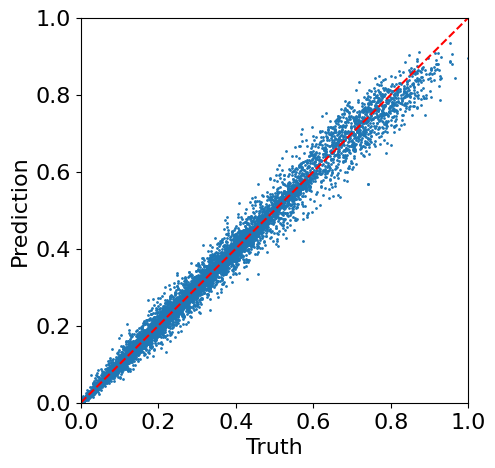

Epoch [2/100]: 100%|█| 1375/1375 [02:14<00:00, 10.22it/s, loss=0.00030


Training acc: 0.000167, Validation accuracy 0.000532


Epoch [3/100]: 100%|█| 1375/1375 [02:09<00:00, 10.59it/s, loss=0.00022


Training acc: 0.000159, Validation accuracy 0.000532


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


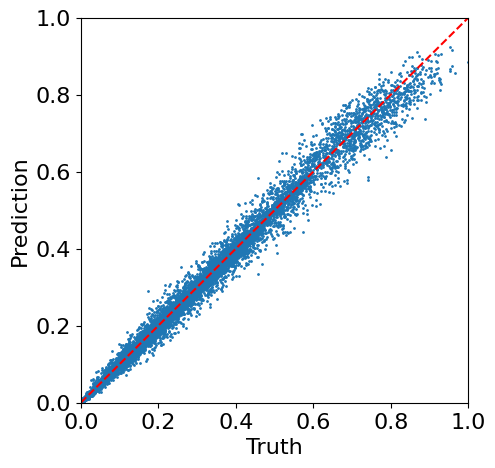

  0%|                      | 0/1375 [00:14<?, ?it/s, val_acc=0.000530]

INFO: Early stopping counter 1 of 5


Epoch [4/100]: 100%|█| 1375/1375 [02:21<00:00,  9.73it/s, loss=0.00012


Training acc: 0.000150, Validation accuracy 0.000530


Epoch [5/100]: 100%|█| 1375/1375 [02:11<00:00, 10.43it/s, loss=0.00010


Training acc: 0.000144, Validation accuracy 0.000530


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


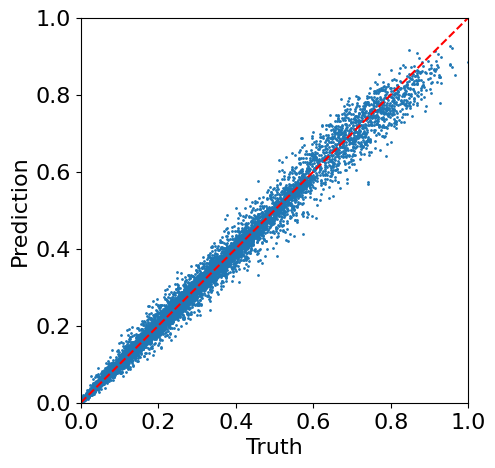

  0%|                      | 0/1375 [00:14<?, ?it/s, val_acc=0.000521]

INFO: Early stopping counter 2 of 5


Epoch [6/100]: 100%|█| 1375/1375 [02:25<00:00,  9.48it/s, loss=0.00018


Training acc: 0.000136, Validation accuracy 0.000521


Epoch [7/100]: 100%|█| 1375/1375 [02:08<00:00, 10.68it/s, loss=0.00011


Training acc: 0.000131, Validation accuracy 0.000521


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


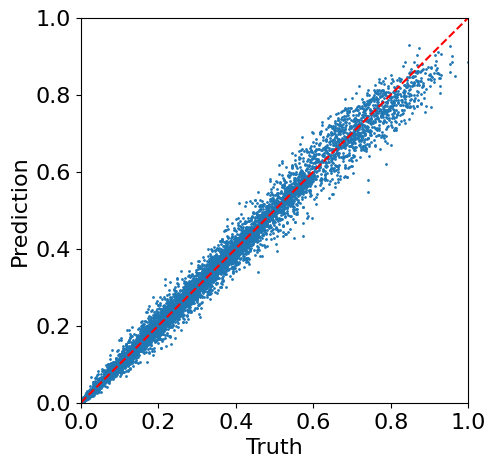

  0%|                      | 0/1375 [00:14<?, ?it/s, val_acc=0.000519]

INFO: Early stopping counter 3 of 5


Epoch [8/100]: 100%|█| 1375/1375 [02:23<00:00,  9.55it/s, loss=0.00013


Training acc: 0.000131, Validation accuracy 0.000519


Epoch [9/100]: 100%|█| 1375/1375 [02:01<00:00, 11.29it/s, loss=0.00011


Training acc: 0.000123, Validation accuracy 0.000519


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


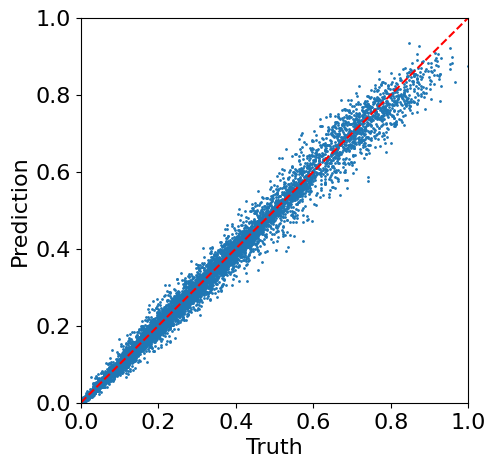

  0%|                      | 0/1375 [00:14<?, ?it/s, val_acc=0.000523]

INFO: Early stopping counter 4 of 5


Epoch [10/100]: 100%|█| 1375/1375 [02:24<00:00,  9.51it/s, loss=0.0001


Training acc: 0.000124, Validation accuracy 0.000523


Epoch [11/100]: 100%|█| 1375/1375 [02:06<00:00, 10.90it/s, loss=0.0002


Training acc: 0.000116, Validation accuracy 0.000523


  0%|                                        | 0/1375 [00:00<?, ?it/s]

Checking accuracy on validation data


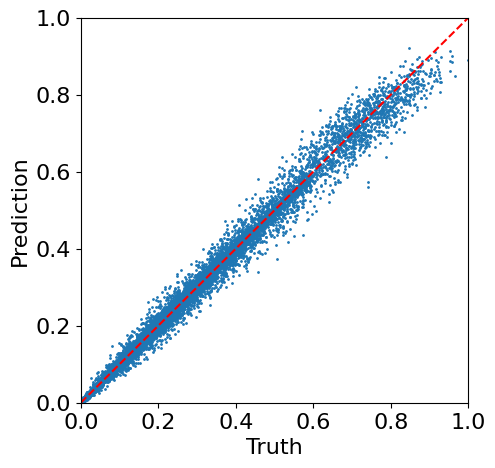

  0%|                      | 0/1375 [00:13<?, ?it/s, val_acc=0.000516]

INFO: Early stopping counter 5 of 5
INFO: Early stopping


In [45]:
stage = 1
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
# model.unlock_base()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()

  0%|                      | 0/1375 [00:13<?, ?it/s, val_acc=0.000516]


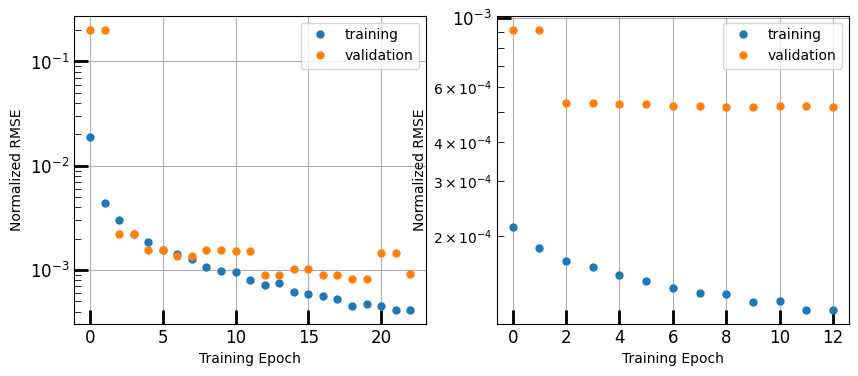

In [46]:
fig = plt.figure(figsize=[10,4])

ax = fig.add_subplot(121)
ax.plot(np.array(par.process['training'][0]), '.', markersize = 10 , label = 'training')
ax.plot(np.array(par.process['validation'][0], dtype = 'float'), '.', markersize = 10 , label = 'validation')
ax.set_yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(which='major',direction = 'in', length = 10, width = 2)
plt.tick_params(which='minor',direction = 'in', length = 5)
ax.set_xlabel('Training Epoch',fontsize = 10)
ax.set_ylabel('Normalized RMSE', fontsize = 10)
plt.grid()
plt.legend(fontsize = 10)

ax = fig.add_subplot(122)
ax.plot(np.array(par.process['training'][1]), '.', markersize = 10 , label = 'training')
ax.plot(np.array(par.process['validation'][1], dtype = 'float'), '.', markersize = 10 , label = 'validation')
ax.set_yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(which='major',direction = 'in', length = 10, width = 2)
plt.tick_params(which='minor',direction = 'in', length = 5)
ax.set_xlabel('Training Epoch',fontsize = 10)
ax.set_ylabel('Normalized RMSE', fontsize = 10)
plt.grid()
plt.legend(fontsize = 10)

# from google.colab import files
# plt.savefig('PINN_benchmark.eps', format='eps')
# files.download("PINN_benchmark.eps") 

In [47]:
np.array(par.process['training'][0])

array([0.01871884, 0.00441744, 0.00300777, 0.00222715, 0.00184401,
       0.00155578, 0.00141123, 0.00127498, 0.00107257, 0.00097186,
       0.00095624, 0.00080216, 0.00071626, 0.0007442 , 0.0006221 ,
       0.00059007, 0.0005672 , 0.00052569, 0.00045222, 0.00046757,
       0.00045371, 0.0004175 , 0.0004175 ], dtype=float32)

In [48]:
torch.save(model.state_dict(), '/home/muller_group/Documents/STEMalign-main/CNNtraining/trained_models/Densenet_25000_aperture30.pt')
par.save_result('/home/muller_group/Documents/STEMalign-main/CNNtraining/trained_models/Densenet_55000_loss_aperture30')

In [49]:
torch.save(model, '/home/muller_group/Documents/STEMalign-main/CNNtraining/trained_models/Densenet_55000_aperture30_entireModel.pt')

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, 1)
# model.load_state_dict(torch.load('/home/muller_group/Documents/STEMalign-main/CNNtraining/trained_models/1_Densenet_25000_aperture0.pt'))

# model.eval()

## Testing on Kraken

In [32]:
# emit = np.load('/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20220725/A1/kraken_A1_emit.npy')
# ronch = np.load('/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20220725/A1/kraken_A1_ronch.npy')
# defocus = np.load('/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20220725/A1/kraken_A1_defocus.npy')

In [113]:
# emit = np.load('/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20220725/A2/kraken_A2_emit.npy')
# ronch = np.load('/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20220725/A2/kraken_A2_ronch.npy')
# defocus = np.load('/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20220725/A2/kraken_A2_defocus.npy')

In [30]:
# emit = np.load('/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20220725/B2/kraken_B2_emit.npy')
# ronch = np.load('/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20220725/B2/kraken_B2_ronch.npy')
# defocus = np.load('/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20220725/B2/kraken_B2_defocus.npy')

In [31]:
# np.amax(ronch[0,:])

In [32]:
# ax1 = plt.figure(figsize = [4,4])
# plt.imshow(ronch[2,:])

In [33]:
# for i in range(4):
#     test_image = []
#     frame = (ronch[i,:])
#     new_channel = np.zeros(frame.shape)
#     img_stack = np.dstack((frame, new_channel, new_channel))
#     test_image.append(img_stack)
#     test_image = np.concatenate([arr[np.newaxis] for arr in test_image])
#     prediction = model(torch.tensor(np.transpose(test_image, (0,3,1,2))).float().contiguous().to(device))
#     print(prediction)

In [34]:
# prediction[0][0]

In [35]:
# emit

In [36]:
# ronch = np.load('/home/muller_group/Documents/STEMalign-main/Kraken_ronch_BO/20220725/kraken_0_ronch.npy')

In [37]:
#     test_image = []
#     frame = (ronch[0,:])
#     new_channel = np.zeros(frame.shape)
#     img_stack = np.dstack((frame, new_channel, new_channel))
#     test_image.append(img_stack)
#     test_image = np.concatenate([arr[np.newaxis] for arr in test_image])
#     prediction = model(torch.tensor(np.transpose(test_image, (0,3,1,2))).float().contiguous().to(device))
#     print(prediction)